<a href="https://colab.research.google.com/github/nightted/Stock_Project/blob/master/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Builder : Tedchang @ 2020.8.15
# Concept want to implement :
1. 利用分點買賣超來計算資金輪動與籌碼轉移
2. 爬取股市爆料同學會資料來判斷淺在漲勢 (EX: 討論區大佬發文(讚>50) ,多人鼓吹 ..)
3. 分析單一股票 , 所有分點買賣-時間,畫成熱度圖以CNN Or RNN vs. 股價  


# TODO LIST:
1. dicts shape not the same , => adjust_dicts function 
2. filter outlier of embedded data
3. pickle file limit , transfer to sqlite , how to do that ?

In [ ]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from datetime import date, timedelta, datetime
import random
 
from PIL import Image 
import matplotlib.pyplot as plt
import pandas as pd
 
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import os

In [ ]:
class BuyerAmount(object):
 
  def __init__(self):
 
    #Default data structure:
    ########################################################################################
    #    {'日期1' : {
    #         分點1 : {股票名1 : 張數1 , 股票名2 : 張數2 . . . . . }
    #         分點2 : {股票名1 : 張數1 , 股票名2 : 張數2 . . . . . }
    #         分點3 : {股票名1 : 張數1 , 股票名2 : 張數2 . . . . . }
    #            .
    #            .
    #              }
    #
    #    '日期2' : {
    #         分點1 : {股票名1 : 張數1 , 股票名2 : 張數2 . . . . . }
    #         分點2 : {股票名1 : 張數1 , 股票名2 : 張數2 . . . . . }
    #         分點3 : {股票名1 : 張數1 , 股票名2 : 張數2 . . . . . }
    #            .
    #            .
    #              }
    ########################################################################################
 
     #New data structure:
    ########################################################################################
    #    {'日期1' : [
    #           [ 股票1 , 股票2 , 股票3 ] <= 分點1
    #           [ 股票1 , 股票2 , 股票3 ] <= 分點2
    #           [ 股票1 , 股票2 , 股票3 ] <= 分點3
    #             .
    #             .
    #              ]
    #
    #    '日期2' : {
    #           [ 股票1 , 股票2 , 股票3 ] <= 分點1
    #           [ 股票1 , 股票2 , 股票3 ] <= 分點2
    #           [ 股票1 , 股票2 , 股票3 ] <= 分點3
    #             .
    #             .
    #              ]
    ########################################################################################
    #Google drive path
    self.BuyAmountList_path = "/content/drive/My Drive/Colab Notebooks/Stock_Project/Stock Data"
    self.test_case = self.PklToData( "/content/drive/My Drive/Colab Notebooks/Stock_Project/Stock_Information/Buyer_dic")  # 所有券商 { (6802,6832):"凱基-虎尾" ,....} 
    self.buyer_index = self.PklToData( "/content/drive/My Drive/Colab Notebooks/Stock_Project/Stock_Information/Buyer_index" ) # 券商 index 對照表 { "凱基-虎尾" : 0 , "凱基-後甲" : 1 ,....} 
    self.stock_index = self.PklToData( "/content/drive/My Drive/Colab Notebooks/Stock_Project/Stock_Information/Stock_List" ) # Stock index 對照表 => {"1101":0 , "1102": .....}
 
    #init process 
    self.BuyAmountList = None # BuyAmountList(Dict)
    self.dates = None
    self.rawdata = None
 
  def load_pkl_data(self ,month = []):
 
    self.BuyAmountList = {}
    print("loading data.....")
    for path in os.listdir(self.BuyAmountList_path):
      mon = path.split(".")[0][-5:]
      if mon in month:
        with open( os.path.join( self.BuyAmountList_path, path) ,'rb') as pkl :
          print(f"loading {mon} data..")
          self.BuyAmountList.update(pickle.load(pkl))
      
    print("loading data sucess!")
 
  def all_dates(self):
 
    return [key for key in self.BuyAmountList.keys()]
 
  def Data_date_select(self ,dic ,dates = None ,merge = True):
    # merge request 
    if dates == None:
      dates = self.all_dates()
   
    if merge: 
      date_list = [ dic[date] for date in dates ]
      if len(date_list) == 1: #dicts only 1 element , return directly
        return date_list[0] 
      
      date_list = data_merge(date_list)  
      return date_list
    
    dicts = { date : dic[date] for date in dates  }
    return dicts #dicts > 1 element , no merge request, return dicts [note that this is list with dicts!] 
 
    
  @staticmethod
  def drop_cln_row(df_buy ,drop_portion = "Buyer" ,Buyer_threshold = 0 ,Upper_bound = 100000000000 , Lower_bound = 0):
    
    sum_axis = 1 if drop_portion == "Buyer" else 0
    drop_axis = 0 if drop_portion == "Buyer" else 1 
 
    if drop_portion == "Buyer":
      #drop_idx_buyer
      df_sum_0 = df_buy.abs().sum(sum_axis)
      #df_sum_0_re = df_sum_0.groupby(pd.cut(df_sum_0,np.arange(0,180000,100))).count() #See the bar-bin distribution of amount 
      drop_idx = df_sum_0[df_sum_0 <= Buyer_threshold].index # 分點買賣<800張的濾掉
      df_buy.drop( drop_idx ,axis = drop_axis, inplace=True)
 
    if drop_portion == "Stock":
      #drop_idx_stock
      df_sum_1 = df_buy.abs().sum(sum_axis) 
      drop_idx_stock_1 = df_sum_1[df_sum_1 >= Upper_bound].index
      drop_idx_stock_2 = df_sum_1[df_sum_1 <= Lower_bound].index
      df_buy.drop(drop_idx_stock_1 ,axis = drop_axis ,inplace=True)
      df_buy.drop(drop_idx_stock_2 ,axis = drop_axis ,inplace=True)
 
    return df_buy #dataframe
  
  @staticmethod
  def buyer_seller_filter(df_buy,filter = "buy"):
 
    df_filter = df_buy.copy()
    if filter == "buy":
      df_filter[df_buy <= 0] = 0 
    # else == "seller"
    if filter == "sell": 
      df_filter[df_buy >= 0] = 0 
    
    return df_filter
  
  def DataToPkl(self , path , data ):
 
    with open( path ,'wb') as pkl :
          pickle.dump( data , pkl )       
          
  def PklToData(self , path ):
      
    with open( path ,'rb') as pkl :
        data = pickle.load( pkl )
 
    return data
 
# Merge and add dicts element and return the added dicts
def data_merge(data_list):
 
  mat_sum_np = 0
  for data in data_list :
    mat = np.array(data) 
    mat_sum_np += mat
  
  return mat_sum_np.tolist()
 
 
def plot(df_buy,size,return_ = True):
 
  Resize = size
  Transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size = (Resize,Resize)),
    transforms.ToTensor(),
  ])
  df_nplist = np.array(df_buy.abs().values.tolist()) # change to np 
  df_nplist_ts = torch.Tensor((df_nplist)) # change to torch.Tensor
  df_nplist_ts = Transformer(df_nplist_ts) # Resize 
  plt.imshow(df_nplist_ts[0]) 
 
  if return_ == True:
    return df_nplist_ts.numpy()
 
 
#Normalize pic 
def normalize(image):
  return (image - image.min()) / (image.max() - image.min())
 
# reducing form of SVD decomposition
def reduce_svd_mat(mat_u ,mat_s ,mat_vt ,reduce_dim = 30):
  
  mat_s = np.diag(mat_s[:reduce_dim])
  mat_u = mat_u[:,:reduce_dim]
  mat_vt = mat_vt[:reduce_dim,:]
  return mat_s , mat_u , mat_vt
 
 
 

####################### Swap the key of dict ####################
 
# the depth of dict
def dict_depth(dic):
    if isinstance(dic, dict): # if is dict type 
        return 1 + (max(map(dict_depth, dic.values())) if dic else 0) # layer+1 and do recursion on the dict.values , and catch the max value in the recursion of dict.value
    return 0
 
# permute lists
def permutation(lists ,permute ):
 
      lists = np.array(lists)
      lists = np.transpose(lists, permute) 
      lists = lists.tolist()  
      return lists 
# transform dict to list 
def DicToMat(dic  , layer_index  , layer_number  , mat_elemet = None  , mat_keyvaluemap = None ):
  
    # Try : re-change the index-keymap to the following flat-form : {"1":[9802,2230],"2":[10/2,10/3,10/4,10/5],"3":[1,2,3]} which is easy to search ?!  
 
    for i , key in enumerate(dic):
 
        # create the layer-key dict : mat_keyvaluemap.
        if layer_index not in mat_keyvaluemap:
            mat_keyvaluemap.update({layer_index:[key]})  
        elif key not in mat_keyvaluemap[layer_index]:
            mat_keyvaluemap[layer_index].append(key)  
            
        if layer_index > 1 :
            mat_elemet.append([]) # if layer_index 不等於 1 (bottom condition) , 則持續加入空 list
            DicToMat(dic = dic[key] , layer_index = layer_index-1 ,layer_number = layer_number ,mat_elemet = mat_elemet[i] ,mat_keyvaluemap = mat_keyvaluemap )  # 利用 recursion 來處理不定layer數目的 dict , layer = layer_index-1 , mat_elemet = mat_elemet[i] 
        else :
            mat_elemet.append(dic[key]) #如果已在最深一層裡, 直接寫入 data  
    return mat_elemet , mat_keyvaluemap
 
# transform list to dict
def MatToDic(mat , maps , layer_index  , layer_number  , dic = None, permute = None ):
    
    # Try : re-change the index-keymap to the following flat-form : {"3":[9802,2230],"2":[10/2,10/3,10/4,10/5],"1":[1,2,3]} which is easy to search ?!
      
    #創造 permutation - index_layer 比對 pairs
    idx_layer_pairs = {}
    for idx ,keys in enumerate(maps.keys()):
        idx_layer_pairs.update({idx:keys})
 
    
    NOW_IN_LAYER = idx_layer_pairs[permute[layer_number-layer_index]] # 從 permute 順序 0 開始 , 逐 layers construct keys in dict  
    if layer_index > 1 :     
        for i , row in enumerate(mat):
            
            key = maps[ NOW_IN_LAYER ][ i ]  # 從 permute 順序 0 開始 , 逐 layers construct keys in dict   
            dic.update({key:{}})  # if layer_index 不等於 1 (not bottom condition) , 則持續加入空 dict (並 construct keys in dict ) 
            MatToDic(mat = mat[i], maps = maps , layer_index = layer_index - 1 , layer_number = layer_number ,  dic = dic[key] , permute = permute  )  # 利用 recursion 來處理不定layer數目的 dict , layer = layer_index-1 , mat = mat[i] , dic = dic[key] 
          
    else :
        for k , ele in enumerate(mat):
            
            key , value = maps[ NOW_IN_LAYER ][ k ] , mat[k]         
            if key not in dic:
                dic.update( { key :  value }  ) #如果已在最深一層裡, 直接寫入 data  
                         
    return dic 
 
#swap keys 
def Swap_Key(dic ,permute ):    
 
    dic_depth = dict_depth(dic) #get the depth of dict
 
    mat_elemet , mat_keyvaluemap = DicToMat( dic  , layer_index = dic_depth , layer_number = dic_depth , mat_elemet = [] , mat_keyvaluemap = {}) # transform dict to matrix
    mat_elemet = permutation(mat_elemet , permute) # matrix permutation 
    new_dic = MatToDic( mat = mat_elemet , maps = mat_keyvaluemap , layer_index = dic_depth , layer_number = dic_depth , permute = permute , dic = {}) # transform matrix to dict
 
    return new_dic 
 
#######################################################
# remove holiday
def delete_key(dicts):
  
  delete_keys = []
  dict_keys = [key for key in dicts.keys()]
  for key in dict_keys:  
    mat = np.array(dicts[key])
    value = np.sum(np.sum(mat,axis = 0),axis = 0)
    if value == 0:
      delete_keys.append(key)
      del dicts[key]
  
  return dicts , delete_keys

def reverse_dic(dicts):
  reverse_dict = {}
  for key , val in dicts.items():
    reverse_dict.update({val:key})
  return reverse_dict

In [ ]:
# get stock_cate-stock_idx pairs 
def load_pickle(path):
  
  with open(path , "rb") as pkl:
    data = pickle.load(pkl)
  return data

stock_list = load_pickle('/content/drive/My Drive/Colab Notebooks/Stock_Project/Stock_Information/Stock_List')
stock_category = load_pickle('/content/drive/My Drive/Colab Notebooks/Stock_Project/Stock_Information/stock_category.pickle')[2]

def get_stockIdx_cate(stock_category,stock_list):
  stockIdex_cate = {}
  record = []
  for key , values in stock_category.items():
    for value in values:
      if value in stock_list:
        if key not in stockIdex_cate:
          stockIdex_cate.update({ key : [stock_list[value]] })
        else:
          stockIdex_cate[key].append(stock_list[value])
        record.append(value)
  '''
  # 檢查烙單的 stock 
  for key , value in stock_list.items():
    if key not in record:
      print(key)
      stockIdex_cate['其他'].append(value)
  烙單 => ['2316','2349','3064','3259','4944','4946']
  '''
  stockIdex_cate['電子零組件'].append(stock_list['2316'])
  stockIdex_cate['其他電子'].append(stock_list['2349'])
  stockIdex_cate['文化創意'].append(stock_list['3064'])
  stockIdex_cate['半導體'].append(stock_list['3259'])
  stockIdex_cate['光電'].append(stock_list['4944'])
  stockIdex_cate['文化創意'].append(stock_list['4946'])

  return stockIdex_cate

In [ ]:
stockIdex_cate = get_stockIdx_cate(stock_category,stock_list)
for key ,value in stockIdex_cate.items():
  print(key ,value)

水泥 [1715, 0, 1, 2, 3, 4, 5]
食品 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 170, 196, 27, 29, 212, 913, 914, 981]
塑膠 [31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 51, 54, 55, 918, 915, 916, 917, 1585, 1709]
紡織纖維 [56, 57, 58, 59, 60, 62, 63, 64, 65, 67, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 927, 932, 933, 919, 920, 921, 922, 924, 925, 926, 928, 930, 931]
電機機械 [105, 106, 107, 108, 110, 111, 112, 114, 115, 120, 121, 122, 123, 124, 125, 126, 128, 130, 131, 132, 133, 134, 135, 136, 143, 147, 148, 255, 337, 648, 940, 945, 951, 959, 961, 964, 966, 968, 969, 971, 972, 973, 1100, 1569, 1588, 1664, 140, 141, 145, 149, 153, 155, 262, 263, 265, 285, 288, 645, 652, 668, 724, 734, 934, 935, 936, 937, 938, 939, 941, 942, 944, 946, 947, 948, 950, 954, 956, 957, 965, 967, 970, 974, 1232, 1384, 1461, 1463, 1502, 1533, 1549, 1573, 1710]
電器電纜 [156, 157, 158, 159

In [ ]:
def TF_IDF(matrix , inverse = True):
  
  #get TF
  if inverse:
    matrix = matrix.T

  sum_stock = np.sum(np.abs(matrix) , axis = 0)
  sum_diag_inv = np.linalg.inv(np.diag(sum_stock))
  TF_ij = matrix@sum_diag_inv
  #get IDF
  nonzero_stock = np.count_nonzero(matrix ,axis = 1)
  IDF_i = np.log(1/(nonzero_stock/matrix.shape[1])) + np.ones(matrix.shape[0])

  #calculate TF-IDF
  IDF_diag = np.diag(IDF_i)
  TF_IDF_ij = IDF_diag@TF_ij

  return TF_IDF_ij.T if inverse else TF_IDF_ij

# data prepross including Buyer&Stock filter , TF_IDFs , buy&sell filter
def data_preprocess(matrix , Buyer_threshold = 0 , CR_filter = True , TF_IDFs = True , BS_filter = True , buy_or_sell = 'buy'):
  
  df_buy = pd.DataFrame(matrix)

  #filter Buyer or Stock
  if CR_filter:
    df_buy = B.drop_cln_row(df_buy ,drop_portion="Buyer" ,Buyer_threshold = Buyer_threshold ) # filter 量少的券商 (預設為0)
    df_buy = B.drop_cln_row(df_buy ,drop_portion="Stock" , Lower_bound = 0 ) # filter 量少的券商 (預設為0)
    np_buy_res = np.array(df_buy.values.tolist())# return to np type

  #TF-IDF
  if TF_IDFs:
    np_buy_res = TF_IDF(np_buy_res)

  #filter buy or sell
  if BS_filter :
    np_buy_res = (np.abs(np_buy_res)+np_buy_res)/2 if buy_or_sell == "buy" else (np.abs(np_buy_res)-np_buy_res)/2
  
  print(f"After preprocessing the matrix shape: {np_buy_res.shape} ")
  return np_buy_res

# normalize with out take sigular value into account  
def new_normalize(matrix ,axis = 1):

  sum_m = np.sum( np.abs(matrix) , axis = axis)
  matrix = matrix if axis else matrix.T
  
  for idx , row in enumerate(matrix):
    if sum_m[idx] == 0 :
      continue
    else :
      matrix[idx] = matrix[idx,:]/sum_m[idx]
  return matrix if axis else matrix.T
  
# Do SVD decomposition and visualize the plot 
def visualize_plot(matrix , reduced_dim = 30, perplexity = 30 , embed = 'stock' ):
 
  #initialize data
  #df_buy = pd.DataFrame(data)
 
  #filter data
  #df_buy = B.buyer_seller_filter(df ,filter = buy_or_sell )
  #df_buy = B.drop_cln_row(df_buy ,drop_portion="Buyer" ,Buyer_threshold = Buyer_threshold )
  #df_buy = B.buyer_seller_filter(df ,filter = buy_or_sell )

  #get SVD decomposition
  u ,s ,vt = np.linalg.svd(matrix ,full_matrices=True)
  print(s)
  mat_s , mat_u , mat_vt = reduce_svd_mat(u ,s ,vt , reduce_dim = reduced_dim)
  print("u shape:",mat_u.shape , "s shape:",mat_s.shape , "vt shape:",mat_vt.shape)
 
  #get embedding vector
  latent_vec = mat_vt.T if embed == "buyer" else mat_u
  embed_vec = TSNE(n_components=2,perplexity=perplexity).fit_transform(latent_vec)

  x, y  = embed_vec.T
  plt.scatter(x,y)
  plt.show()

  return embed_vec 

In [ ]:
# merge same type of industry (real and fake)
def grouping_stock(matrix , stockIdex_cate ,  fake = False):

  shape_1 = len(stockIdex_cate) if not fake else 33 # matrix.shape[0] = 962 , matrix.shape[1] = 1716
  merge_matrix = np.zeros((matrix.shape[0],shape_1))
  merge_column = 0

  # if it's real data
  if not fake:
    for key , values in stockIdex_cate.items():
      dummy = 0
      for value in values:
        dummy += matrix[ : , int(value) : int(value)+1 ]
      merge_matrix[ : , merge_column :merge_column+1 ] = dummy
      merge_column += 1
  # if it's fake data
  else:
    dummy = 0
    for idx , number in enumerate(shuffle_lists):
      dummy += matrix[ : , number : number+1 ]  
      if (idx+1)%(matrix.shape[1]/shape_1) == 0: # 33 一個 loop   
        merge_matrix[ : , merge_column :merge_column+1 ] = dummy
        dummy = 0
        merge_column += 1

  print(f"After grouping the matrix shape :{merge_matrix.shape}")
  return merge_matrix

In [ ]:
B = BuyerAmount()
B.load_pkl_data(month = ['19-06']) # '19-07','19-08','19-09','19-10','19-11','19-12'

loading data.....
loading 19-06 data..
loading data sucess!


In [ ]:
# Loading & Stacking data 
keys = [ key for key in sorted(B.BuyAmountList.keys())]
np_dummy = []
for idx , key in enumerate(keys):
  if idx < 5000 and idx > -1:
    np_dummy.append(B.BuyAmountList[key])
    del B.BuyAmountList[key] # release dicts RAM memory
np_dummy = np.array(np_dummy)

# Raw-Data (and fake) collect

In [ ]:
# real data
data_sum = np.sum(np_dummy , axis=0)
data_sum.shape

(962, 1716)

In [ ]:
# fake data
data_sum_f = data_sum.copy()
for i in range(data_sum_f.shape[0]):
  random.shuffle(data_sum_f[i])
print(data_sum_f.shape)

shuffle_lists = list(range(0,1716))
random.shuffle(shuffle_lists)
print(shuffle_lists)

(962, 1716)
[1528, 119, 0, 1622, 744, 263, 1508, 471, 464, 1131, 1575, 1121, 585, 226, 1277, 653, 264, 473, 1296, 403, 813, 25, 659, 966, 1350, 1377, 1001, 1222, 1122, 499, 1677, 1163, 1454, 607, 282, 1627, 1244, 443, 738, 167, 750, 1245, 1455, 1605, 156, 1225, 1676, 1049, 764, 765, 1656, 542, 1440, 1031, 259, 290, 576, 616, 1084, 1715, 1021, 1299, 566, 951, 794, 1393, 902, 513, 599, 804, 4, 936, 283, 288, 526, 783, 489, 1090, 1060, 1271, 1116, 920, 539, 78, 314, 344, 953, 32, 422, 35, 1183, 666, 423, 683, 807, 124, 817, 757, 50, 57, 1529, 606, 91, 160, 166, 755, 1190, 196, 198, 504, 492, 348, 1351, 1078, 463, 1707, 1496, 1587, 1408, 1594, 770, 1649, 680, 185, 207, 493, 555, 5, 1488, 1048, 1547, 248, 1255, 478, 391, 63, 823, 120, 1221, 1523, 1418, 1189, 111, 714, 818, 1564, 719, 1696, 171, 690, 292, 73, 1391, 850, 1250, 405, 297, 948, 835, 849, 927, 1185, 1251, 1693, 749, 766, 66, 1562, 267, 20, 575, 44, 640, 1211, 696, 1434, 1384, 915, 70, 960, 793, 382, 887, 983, 1333, 109, 655, 1346

# Data preprocess including filter low buyer , TF-IDF , filter buy-or-sell

In [ ]:
# data group merge(fake)
merge_matrix_f = grouping_stock(data_sum_f , stockIdex_cate , fake = True )
# data preprocess(fake)
np_buy_res_f = data_preprocess(merge_matrix_f , Buyer_threshold = 0 , filter = True , buy_or_sell = 'buy') 

After grouping the matrix shape :(962, 33)
After preprocessing the matrix shape: (882, 33) 


In [ ]:
# data group merge(fake)
merge_matrix = grouping_stock(data_sum , stockIdex_cate , fake = False )
#exclude #光電 #半導體 #金融 族群 (因大部分分點前會幾名大量買賣 , 擾亂分點籌碼特性)
new_1 ,new_2 ,new_3 ,new_4 = merge_matrix[:,:13] , merge_matrix[:,14:15] , merge_matrix[:,16:24] , merge_matrix[:,25:]
merge_matrix = np.concatenate((new_1 ,new_2 ,new_3 ,new_4), axis = 1)
# data preprocess(real)
np_buy_res = data_preprocess(merge_matrix , Buyer_threshold = 0 , BS_filter = True , buy_or_sell = 'buy') 

After grouping the matrix shape :(962, 33)
After preprocessing the matrix shape: (882, 30) 


[2.71637414 1.71863407 1.59773826 1.57261104 1.53431646 1.50575245
 1.45817537 1.38259147 1.35954851 1.32486729 1.20214947 1.02168158
 0.98845382 0.94524755 0.9008576  0.89124035 0.87540799 0.87109212
 0.82384156 0.80559074 0.7866373  0.74921972 0.69544384 0.65899721
 0.62781219 0.61212959 0.57017339 0.52480572 0.35552478 0.34264826
 0.32143472 0.29992756 0.25555393]
u shape: (882, 20) s shape: (20, 20) vt shape: (20, 33)


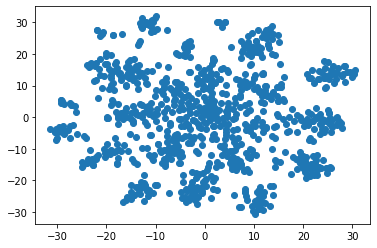

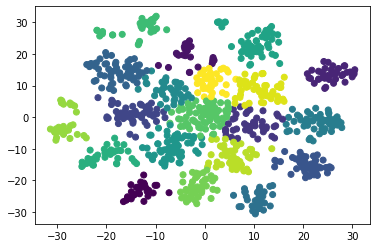

In [ ]:
embed_vec_f = visualize_plot(np_buy_res_f , reduced_dim = 20 , perplexity = 30)
kmeans_f = KMeans(n_clusters=20, random_state=0).fit(embed_vec_f)
plt.scatter(embed_vec_f[:,0],embed_vec_f[:,1], c=kmeans_f.labels_)

[3.01041697 1.98126774 1.82149006 1.68463301 1.53536976 1.44397574
 1.36904148 1.28498919 1.26500512 1.19775885 1.1864118  1.16167416
 1.05335175 0.9559589  0.90912244 0.87836161 0.84723971 0.82303054
 0.78704877 0.77253849 0.73007433 0.7071439  0.59574076 0.53284662
 0.466999   0.45713714 0.42747544 0.41973499 0.29450284 0.12956901]
u shape: (882, 20) s shape: (20, 20) vt shape: (20, 30)


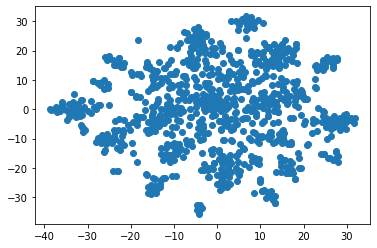

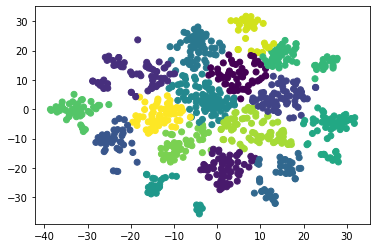

In [ ]:
embed_vec = visualize_plot( np_buy_res , reduced_dim = 20 , perplexity = 30 )
kmeans = KMeans(n_clusters=16, random_state=0).fit(embed_vec)
plt.scatter(embed_vec[:,0],embed_vec[:,1], c=kmeans.labels_)

In [ ]:
kmeans.cluster_centers_

array([[  5.0128183 ,  11.495436  ],
       [  1.8214431 , -20.193161  ],
       [-19.12021   ,  12.060943  ],
       [ 14.98853   ,   4.035968  ],
       [-23.79269   , -10.852302  ],
       [ 13.980817  , -22.99373   ],
       [ -4.6475196 ,  20.934542  ],
       [ -2.8160985 ,   3.493253  ],
       [-11.232639  , -28.017645  ],
       [ 26.328468  ,  -7.1435957 ],
       [ 18.40118   ,  17.33802   ],
       [-32.722572  ,  -0.53306115],
       [ -8.010107  , -12.048846  ],
       [  8.906368  ,  -7.174449  ],
       [  7.832222  ,  26.37463   ],
       [-13.24849   ,  -2.1858292 ]], dtype=float32)

In [ ]:
def group_plot(matrix , group , label = kmeans.labels_):  
  group_member = []
  for idx,ele in enumerate(kmeans.labels_):
    if ele == group :
      group_member.append(idx)
  group_matrix = np.zeros((len(group_member),matrix.shape[1]))
  for idx , ele in enumerate(group_member):
    group_matrix[ idx : idx+1 , : ] = matrix[ group_member[idx]: group_member[idx]+1 , :]
  plt.imshow(group_matrix)
  plt.colorbar()

  return group_matrix , group_member

In [ ]:
# 測試: 抓出當中的一個 group(fake)  
#group = 10
#group_matrix_f , group_member_f = group_plot(np_buy_res_f, group)

In [ ]:
# TODO : 這邊要注意 merge_matrix_d (shape : 882 , 30 ) 才是跟 np_buy_res shape 對齊的 raw data!!!! (用原本的 merge_matrix shape : 962 , 30 找 group member 買賣量會出錯@@ !!!)
merge_matrix_d = data_preprocess(merge_matrix , Buyer_threshold = 0 , CR_filter = True , TF_IDFs = False , BS_filter = True , buy_or_sell = 'buy') 

After preprocessing the matrix shape: (882, 30) 


In [ ]:
df = pd.DataFrame(merge_matrix_d)
merge_matrix_d[50,:]

array([ 4730.,  1642.,   825.,     0.,     0.,     0.,  4429.,     0.,
          78.,     0.,     0.,     0.,     0.,     0.,  5390.,  9784.,
           0.,     0., 15532.,     0.,  1643.,     0., 10717.,  1686.,
           0.,  2854.,    93.,   100.,     0.,     0.])

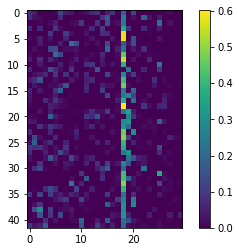

In [ ]:
merge_matrix_d = new_normalize(merge_matrix_d)
merge_matrix_d.shape
group_ , member_ = group_plot(merge_matrix_d,group=4)

42
the buyer 土銀-彰化 buy 119.0 stocks! 
the buyer 中國信託-嘉義 buy 15532.0 stocks! 
the buyer 元大-竹東 buy 205.0 stocks! 
the buyer 元大-竹科 buy 387.0 stocks! 
the buyer 元大-佳里 buy 859.0 stocks! 
the buyer 元大-林園 buy 1026.0 stocks! 
the buyer 元大-前金 buy 131.0 stocks! 
the buyer 元大-國際證券 buy 370.0 stocks! 
the buyer 元大-博愛 buy 662.0 stocks! 
the buyer 元大-頭份 buy 1225.0 stocks! 
the buyer 元富-中港 buy 229.0 stocks! 
the buyer 元富-吉利 buy 17.0 stocks! 
the buyer 元富-板橋 buy 138.0 stocks! 
the buyer 元富-敦南 buy 402.0 stocks! 
the buyer 日盛-中和 buy 183.0 stocks! 
the buyer 日盛-竹北 buy 653.0 stocks! 
the buyer 日盛-花蓮 buy 430.0 stocks! 
the buyer 日進 buy 1477.0 stocks! 
the buyer 台新銀 buy 683.0 stocks! 
the buyer 台灣企銀 buy 491.0 stocks! 
the buyer 台灣匯立證券 buy 0.0 stocks! 
the buyer 永興-大墩 buy 233.0 stocks! 
the buyer 永興-台中 buy 309.0 stocks! 
the buyer 永豐金-國際證券 buy 468.0 stocks! 
the buyer 永豐金-敦南 buy 427.0 stocks! 
the buyer 兆豐-北高雄 buy 474.0 stocks! 
the buyer 兆豐-忠孝 buy 701.0 stocks! 
the buyer 宏遠-桃園 buy 577.0 stocks! 
the buyer 亞

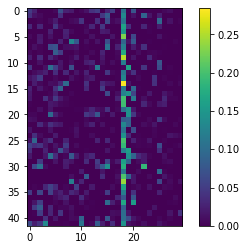

In [ ]:
# 測試: 抓出當中的一個 group(real)  
group = 4
group_matrix , group_member = group_plot(np_buy_res,group)
print(len(group_member))
# TODO : 這邊要注意 merge_matrix_d (shape : 882 , 30 ) 才是跟 np_buy_res shape 對齊的 raw data!!!! (用原本的 merge_matrix shape : 962 , 30 找 group member 買賣量會出錯@@ !!!)
# TODO : 另外注意到 member 買賣量 = 0.0 的代表原本買賣量是負的 (因為BS filter過了~)
for member in group_member:
  print(f"the buyer {Idx_to_buyer(member)} buy {merge_matrix_d[member][18]} stocks! ")

In [ ]:
def Idx_to_buyer(idx):
  rev_dic = reverse_dic(B.buyer_index)
  return rev_dic[idx]

After preprocessing the matrix shape: (888, 1683) 
塑膠 1.1658324556622661
通信網路 0.698034638674576
金融 0.2810798268437051
其他 0.2252447449562955
塑膠 0.2093061811466958
塑膠 0.19656330052276166
觀光 0.1929208179304929
鋼鐵 0.18170433380331683
電器電纜 0.15653646472102595
塑膠 0.15498454762352287
塑膠 0.15417749035707742
塑膠 0.139043970287354
塑膠 0.1289159465625613
其他電子 0.12865744627181536
塑膠 0.12728638751441085
通信網路 0.11788800866904617
通信網路 0.1150289580978685
塑膠 0.11375560264804953
其他電子 0.11095424211518991
橡膠 0.1099616779470113
電子零組件 0.10612651926170767
航運業 0.10028509535989798
電腦及週邊設備 0.09879468561567716
電腦及週邊設備 0.09791080788628058
塑膠 0.09727581941496007
造紙 0.09635153652003857
食品 0.09467723675308078
其他電子 0.09424745897967678
航運業 0.08993322422661107
電腦及週邊設備 0.08647918881841715
化工 0.08412490673128825
電腦及週邊設備 0.08155034829031067
食品 0.08039050030715968
紡織纖維 0.0765761599437172
塑膠 0.07632423724836737
電子零組件 0.0760104465691149
電子零組件 0.07355356554983267
電子通路 0.07192646364817988
電子零組件 0.07122388386430581
通信網路 0.0711143

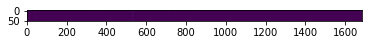

In [ ]:
# TODO 測試: 以此 group = 9 (營建類股) 抓出的焦點券商 , 反利用原始 raw matrix , 檢查這些焦點券商買超的個股是那些 ?
# 如果是 fake matrix 結果會?
np_data_sum = data_preprocess(data_sum , Buyer_threshold = 0 , filter = True , buy_or_sell = 'buy') # filter and normalize 原始 raw matrix
group_matrix_full , member = group_plot(np_data_sum , group) # 取出 group 9 的券商

df = pd.DataFrame(group_matrix_full)
#df_ = df.sum(0)
#l = df_.values.tolist()
#sorted(l)
df = B.drop_cln_row(df , drop_portion= "Stock" ,Lower_bound=0)
df_np = np.array(df.values.tolist())
#plt.imshow(df_np)
df_sum = df.sum(0) # sum over every stock 
df_sum = df_sum.sort_values(ascending=False) # sort by 各股 stock 買賣量  
idx_list = df_sum.index.tolist()
value_list = df_sum.values.tolist()

# 印出此 group 券商前幾買賣的產業類別
data_dummy = []
for idx ,value in zip(idx_list,value_list):
  for key ,values in stockIdex_cate.items():
    if idx in values:
      data_dummy.append((key,value))
      if key not in ["光電","金融保險","半導體"]:
        print(key,value)


(array([1., 3., 5., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([   0.  ,   13.89,   27.78,   41.67,   55.56,   69.45,   83.34,
          97.23,  111.12,  125.01,  138.9 ,  152.79,  166.68,  180.57,
         194.46,  208.35,  222.24,  236.13,  250.02,  263.91,  277.8 ,
         291.69,  305.58,  319.47,  333.36,  347.25,  361.14,  375.03,
         388.92,  402.81,  416.7 ,  430.59,  444.48,  458.37,  472.26,
         486.15,  500.04,  513.93,  527.82,  541.71,  555.6 ,  569.49,
         583.38,  597.27,  611.16,  625.05,  638.94,  652.83,  666.72,
         680.61,  694.5 ,  708.39,  722.28,  736.17, 

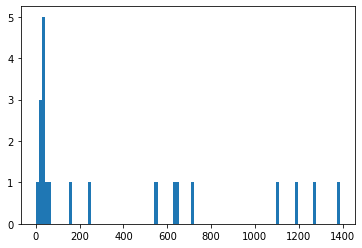

In [ ]:
y = []
for idx ,data in enumerate(data_dummy):
  if data[0] == "塑膠":
    y.append(idx)
plt.hist(y, bins = 100)

In [ ]:
for key ,value in stockIdex_cate.items():
  print(key ,value)

水泥 [1715, 0, 1, 2, 3, 4, 5]
食品 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 170, 196, 27, 29, 212, 913, 914, 981]
塑膠 [31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 51, 54, 55, 918, 915, 916, 917, 1585, 1709]
紡織纖維 [56, 57, 58, 59, 60, 62, 63, 64, 65, 67, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 927, 932, 933, 919, 920, 921, 922, 924, 925, 926, 928, 930, 931]
電機機械 [105, 106, 107, 108, 110, 111, 112, 114, 115, 120, 121, 122, 123, 124, 125, 126, 128, 130, 131, 132, 133, 134, 135, 136, 143, 147, 148, 255, 337, 648, 940, 945, 951, 959, 961, 964, 966, 968, 969, 971, 972, 973, 1100, 1569, 1588, 1664, 140, 141, 145, 149, 153, 155, 262, 263, 265, 285, 288, 645, 652, 668, 724, 734, 934, 935, 936, 937, 938, 939, 941, 942, 944, 946, 947, 948, 950, 954, 956, 957, 965, 967, 970, 974, 1232, 1384, 1461, 1463, 1502, 1533, 1549, 1573, 1710]
電器電纜 [156, 157, 158, 159

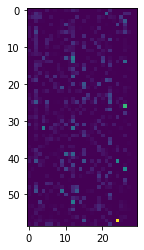

In [ ]:
group_matrix = group_plot(new_mat , 0 )

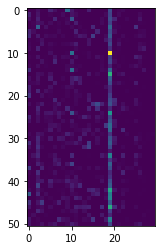

In [ ]:
group_matrix = group_plot(new_mat , 1 )

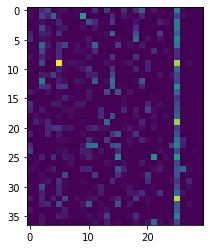

In [ ]:
group_matrix = group_plot(new_mat , 2 )

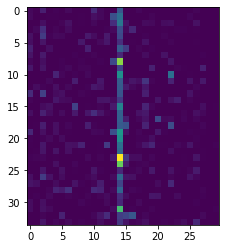

In [ ]:
group_matrix = group_plot(new_mat , 3 )

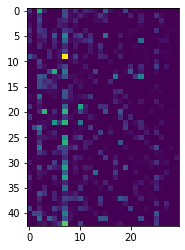

In [ ]:
group_matrix = group_plot(new_mat , 4 )

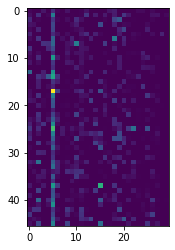

In [ ]:
group_plot(new_mat , 5 )

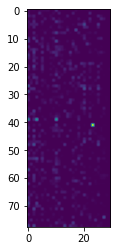

In [ ]:
group_plot(new_mat , 6 )

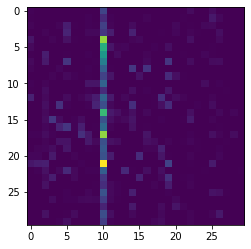

In [ ]:
group_plot(new_mat , 7 )

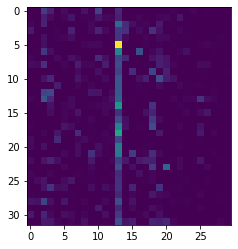

In [ ]:
group_plot(new_mat , 8 )

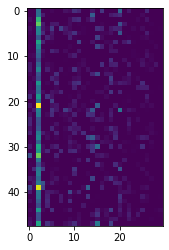

In [ ]:
group_plot(new_mat , 9 )

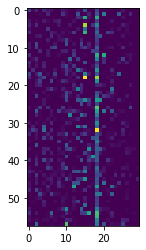

In [ ]:
group_plot(new_mat , 10 )

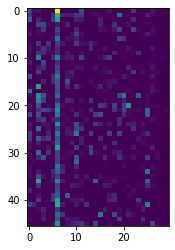

In [ ]:
group_plot(new_mat , 11 )

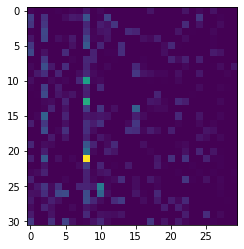

In [ ]:
group_plot(new_mat , 12 )

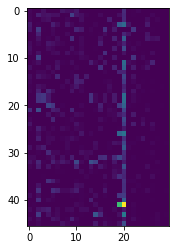

In [ ]:
group_plot(new_mat , 13 )

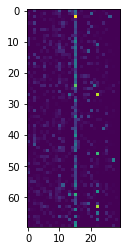

In [ ]:
group_plot(new_mat , 14 )

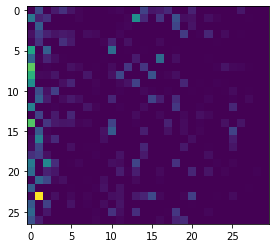

In [ ]:
group_plot(new_mat , 15 )

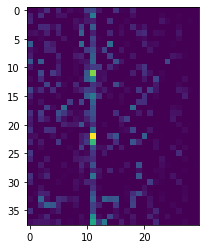

In [ ]:
group_plot(new_mat , 16 )

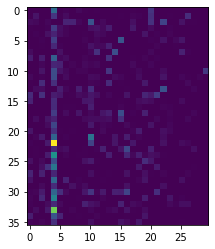

In [ ]:
group_plot(new_mat , 17 )

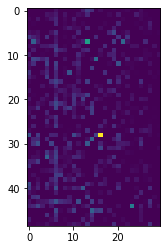

In [ ]:
group_plot(new_mat , 18 )

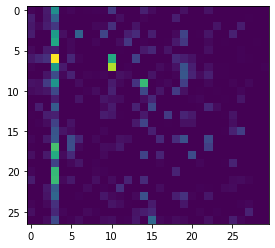

In [ ]:
group_plot(new_mat , 19 )

# 這邊想大概解釋一下為何 "group shuffle" 對 t-SNE 結果看起來影響不大:
1. 這裡先解釋為何一開始沒做 stock grouping 做不太出來 , 原因很簡單 , 因為 group 數量太多(1716) , 買家數量(962)遠小於它 , 故大部分 matrix element 都等於0 , 換句話說 data 太分散 , 或者是說意思是買家之間的有意義的交集太少 (有點像是將一個人的特徵或個性分成了幾千幾萬種,這樣每個人幾乎都是獨一無二的個體了! ), 做 factorization 降維後結果就是超級多的小團體,當然看不出來! 

2. 做grouping(產業類別)後 , 特徵量減少且更加精簡 , 自然對買家的特性差異更一目了然 ; 但這邊回到問題: 為何 feature group shuffle 後結果似乎跟原本定義好的 group 結果類似呢 ? 原因其實也很單純 , 試想一個例子: 假設買家1 跟買家2 一樣都愛好我定義好的產業 A , B , C(假設他們倆都各投資一百張), 今天假設我"重新定義了產業類別", 也就是 A ,B ,C 裡的某些公司甲乙丙, 都被重新分配到了新的產業分類裡 (EX: A_甲 -> C , A_乙 -> D)  , 那買家1 對 A ,B ,C裡面各投資的100張 ,就會被"切割"到新的類別裡,
但這邊注意到 ,買家2 的投資 , 一樣的被切割到了"一樣的新的產業類別"裡! 簡單來說結論就是, 兩個投資理念一樣的人,不管產業類別怎麼 grouping , 他們都投資理念 (latent vector) 是不太會受影響的! 故他們之間做完 t-SNE 的結果應該也不會有太大的差距!  

In [ ]:
df_sum_0 = df_buy.abs().sum(axis=0)
print(len(df_sum_0))
df_sum_0_re = df_sum_0.groupby(pd.cut(df_sum_0,np.arange(0,180000,100))).count()
df_sum_0_re 

962


(0, 100]            1
(100, 200]          0
(200, 300]          0
(300, 400]          3
(400, 500]          7
                   ..
(179400, 179500]    0
(179500, 179600]    0
(179600, 179700]    0
(179700, 179800]    0
(179800, 179900]    0
Length: 1799, dtype: int64

In [ ]:
#for i ,j in enumerate(df_sum_0_re):
#  print(("{}~{}:".format((i)*100,(i+1)*100),j))

#　Comment :　800張以下的點全砍

In [ ]:
drop_idx = df_sum_0[df_sum_0 < 800].index # 分點買賣<800張的濾掉
print("drop ratio:{}%".format(len(drop_idx)/len(df_sum_0)*100))
drop_idx

drop ratio:15.800415800415802%


Index(['土銀-士林', '土銀-玉里', '土銀-白河', '土銀-和平', '土銀-南港', '土銀-建國', '大展-台南', '大鼎',
       '大慶-中和', '大慶-台南',
       ...
       '德信-三重', '德信-台北(停)', '德信-和平', '聯邦-大業', '聯邦-富強', '聯邦-嘉義', '聯邦-興中', '豐銀',
       '豐德', '豐興'],
      dtype='object', length=152)

In [ ]:
df_buy.drop(drop_idx,axis = 1,inplace=True)
df_buy

,(牛牛牛)亞證券,(牛牛牛)亞-網路,(牛牛牛)亞-鑫豐,土銀,土銀-台中,土銀-台南,土銀-花蓮,土銀-高雄,土銀-新竹,土銀-嘉義,土銀-彰化,大和國泰,大昌,大昌-安康,大昌-桃園,大昌-新竹,大昌-新店,大昌-樹林,大展,大慶,大慶-中壢,大慶-台中,大慶-長榮,大慶-泰山,大慶-富順,大慶-楊梅,大慶-蘆洲,中國信託,中國信託-三重,中國信託-中壢,中國信託-文心,中國信託-永康,中國信託-忠孝,中國信託-松江,中國信託-高雄,中國信託-新竹,中國信託-嘉義,中農,元大證券,元大-八德,...,群益金鼎-海山,群益金鼎-高盛,群益金鼎-高雄,群益金鼎-基隆,群益金鼎-崇德,群益金鼎-敦南,群益金鼎-開元,群益金鼎-新竹,群益金鼎-新店,群益金鼎-新莊,群益金鼎-瑞豐,群益金鼎-萬華,群益金鼎-經國,群益金鼎-嘉義,群益金鼎-彰化,群益金鼎-鳳山,群益金鼎-潭子,群益金鼎-館前,彰銀,彰銀-台中,福邦證券,福勝,臺銀,臺銀-民權,臺銀-金山,臺銀-高雄,臺銀-新竹,臺銀-臺中,臺銀-臺南,臺銀-鳳山,德信,德信-中正,德信-新營,摩根大通,聯邦商銀,聯邦-三重,聯邦-高雄,聯邦-敦化,聯邦-雙和,豐農
1102,0,0,0,4,0,0,0,8,0,45,0,400,0,0,0,0,0,0,0,10,0,0,0,0,11,8,0,0,0,47,23,0,0,7,0,10,21,0,-2216,0,...,16,0,0,0,6,0,0,-7,0,0,0,0,-17,0,0,0,0,0,0,5,0,0,0,0,16,0,0,14,0,0,0,0,0,-566,0,2,-6,1,0,0
1103,0,0,0,0,0,0,0,0,-13,0,0,0,0,0,0,-10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-4,0,0,0,0
1104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1108,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1109,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9955,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-4,0,0,0,...,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,23,0,0,0,0,0,0,0,2,0,0
9958,0,0,0,0,0,4,4,0,0,0,0,0,0,0,-7,-11,0,0,-8,-27,0,0,0,0,-13,-7,0,0,0,9,0,-14,43,0,0,-30,-4,0,0,0,...,0,0,0,11,0,0,0,0,7,0,0,0,0,13,55,13,0,0,0,9,0,0,0,17,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0
9960,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9962,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Stock aspect
df_buy.abs().sum(axis=1)

1102    12283
1103      793
1104      160
1108      177
1109       20
        ...  
9955      490
9958     4101
9960        0
9962       67
1101    14579
Length: 1716, dtype: int64

In [ ]:
df_sum_1 = df_buy.abs().sum(axis=1) #這邊不該用 abs() , 因為有賣超(負)的存在, 後續會再修改
df_sum_1_re = df_sum_1.groupby(pd.cut(df_sum_1,np.arange(0,180000,100))).count()
df_sum_1_re

(0, 100]            548
(100, 200]          175
(200, 300]          104
(300, 400]           70
(400, 500]           57
                   ... 
(179400, 179500]      0
(179500, 179600]      0
(179600, 179700]      0
(179700, 179800]      0
(179800, 179900]      0
Length: 1799, dtype: int64

In [ ]:
'''
def DicToMat_2D(dic):
    
    mat_elemet = []
    mat_keyvaluemap = []
    for i , key in enumerate(dic):           
        mat_elemet.append([])
        mat_keyvaluemap.append([])
        
        for j , subkey in enumerate(dic[key]):             
            mat_elemet[i].append(dic[key][subkey])
            mat_keyvaluemap[i].append((key,subkey))
    
    return mat_elemet , mat_keyvaluemap
    
def MatToDic_2D(mat, maps , swap = False):
    
    def transpose(lists):        
        lists = np.array(lists)
        lists = np.swapaxes(lists,1,0).tolist()
        return lists    
    
    dic = {}
    key_idx,subkey_idx = 0 , 1 
    if swap:   
        #if want to swap the dict key ,value 
        maps , mat = transpose(maps) ,transpose(mat)
        key_idx,subkey_idx = 1 , 0   # need reverse the priority of key&subkey due to transpose of maps matrix  
                            
    for i , row_ele in enumerate(mat):      
        for j , col_ele in enumerate(mat[i]):             
            key ,subkey , value = maps[i][j][key_idx], maps[i][j][subkey_idx], mat[i][j]          
            if key not in dic:
                dic.update( { key : { subkey : value } } )
            else:
                dic[key].update({subkey : value})                                   
    return dic

  
d1 = {
    "10/1":{"1":12,"2":56,"3":22},
    "10/2":{"1":14,"2":78,"3":4},
    "10/3":{"1":1,"2":6,"3":108},
}

d2 = {
    "10/1":{"1":12,"2":56,"3":22},
    "10/2":{"1":14,"2":78,"3":4},
    "10/3":{"1":1,"2":6,"3":108},
}

def DicToMat_1(dic  , layer_index , layer_number = 3 ,mat_elemet = [] ,mat_keyvaluemap = [] ,dummy_key = []):
  
    if layer_index > 1 :
        
        for i , key in enumerate(dic):
            
            mat_elemet.append([])
            mat_keyvaluemap.append([])     
            dummy_key.append(key)
            DicToMat_2(dic[key] , layer_index-1 ,mat_elemet = mat_elemet[i] ,mat_keyvaluemap = mat_keyvaluemap[i] ,dummy_key = dummy_key) 
            dummy_key.pop()
          
    else :
        
        for k , key in enumerate(dic):
            
            dummy_key.append(key)
            mat_elemet.append(dic[key])
            mat_keyvaluemap.append(dummy_key.copy())
            dummy_key.pop()  # remove the last element 
        
    return mat_elemet , mat_keyvaluemap
            

'''

In [ ]:
dict_sample = {"9802":{"10/2":{'1':[1,2],'2':[1,2],'3':[1,2]},"10/3":{'1':[1,2],'2':[1,2],'3':[1,2]},"10/4":{'1':[1,2],'2':[1,2],'3':[1,2]},"10/5":{'1':[1,2],'2':[1,2],'3':[1,2]}},"2330":{"10/2":{'1':[1,2],'2':[1,2],'3':[1,2]},"10/3":{'1':[1,2],'2':[1,2],'3':[1,2]},"10/4":{'1':[1,2],'2':[1,2],'3':[1,2]},"10/5":{'1':[1,2],'2':[1,2],'3':[1,2]}}}
dict_sample

{'2330': {'10/2': {'1': [1, 2], '2': [1, 2], '3': [1, 2]},
  '10/3': {'1': [1, 2], '2': [1, 2], '3': [1, 2]},
  '10/4': {'1': [1, 2], '2': [1, 2], '3': [1, 2]},
  '10/5': {'1': [1, 2], '2': [1, 2], '3': [1, 2]}},
 '9802': {'10/2': {'1': [1, 2], '2': [1, 2], '3': [1, 2]},
  '10/3': {'1': [1, 2], '2': [1, 2], '3': [1, 2]},
  '10/4': {'1': [1, 2], '2': [1, 2], '3': [1, 2]},
  '10/5': {'1': [1, 2], '2': [1, 2], '3': [1, 2]}}}

In [ ]:
def dict_depth(dic):
    if isinstance(dic, dict): # if is dict type 
        return 1 + (max(map(dict_depth, dic.values())) if dic else 0) # layer+1 and do recursion on the dict.values , and catch the max value in the recursion of dict.value
    return 0

# permute lists
def permutation(lists ,permute ):

      lists = np.array(lists)
      lists = np.transpose(lists, permute) 
      lists = lists.tolist()  
      return lists 

# transform dict to list 
def DicToMat(dic  , layer_index  , layer_number  , mat_elemet = None  , mat_keyvaluemap = None ):
  
    # Try : re-change the index-keymap to the following flat-form : {"1":[9802,2230],"2":[10/2,10/3,10/4,10/5],"3":[1,2,3]} which is easy to search ?!  

    for i , key in enumerate(dic):

        # create the layer-key dict : mat_keyvaluemap.
        if layer_index not in mat_keyvaluemap:
            mat_keyvaluemap.update({layer_index:[key]})  
        elif key not in mat_keyvaluemap[layer_index]:
            mat_keyvaluemap[layer_index].append(key)  
            
        if layer_index > 1 :
            mat_elemet.append([]) # if layer_index 不等於 1 (bottom condition) , 則持續加入空 list
            DicToMat(dic = dic[key] , layer_index = layer_index-1 ,layer_number = layer_number ,mat_elemet = mat_elemet[i] ,mat_keyvaluemap = mat_keyvaluemap )  # 利用 recursion 來處理不定layer數目的 dict , layer = layer_index-1 , mat_elemet = mat_elemet[i] 
        else :
            mat_elemet.append(dic[key]) #如果已在最深一層裡, 直接寫入 data  
    return mat_elemet , mat_keyvaluemap

# transform list to dict
def MatToDic(mat , maps , layer_index  , layer_number  , dic = None, permute = None ):
    
    # Try : re-change the index-keymap to the following flat-form : {"3":[9802,2230],"2":[10/2,10/3,10/4,10/5],"1":[1,2,3]} which is easy to search ?!
      
    #創造 permutation - index_layer 比對 pairs
    idx_layer_pairs = {}
    for idx ,keys in enumerate(maps.keys()):
        idx_layer_pairs.update({idx:keys})

    
    NOW_IN_LAYER = idx_layer_pairs[permute[layer_number-layer_index]] # 從 permute 順序 0 開始 , 逐 layers construct keys in dict  
    if layer_index > 1 :     
        for i , row in enumerate(mat):
            
            key = maps[ NOW_IN_LAYER ][ i ]  # 從 permute 順序 0 開始 , 逐 layers construct keys in dict   
            dic.update({key:{}})  # if layer_index 不等於 1 (not bottom condition) , 則持續加入空 dict (並 construct keys in dict ) 
            MatToDic(mat = mat[i], maps = maps , layer_index = layer_index - 1 , layer_number = layer_number ,  dic = dic[key] , permute = permute  )  # 利用 recursion 來處理不定layer數目的 dict , layer = layer_index-1 , mat = mat[i] , dic = dic[key] 
          
    else :
        for k , ele in enumerate(mat):
            
            key , value = maps[ NOW_IN_LAYER ][ k ] , mat[k]         
            if key not in dic:
                dic.update( { key :  value }  ) #如果已在最深一層裡, 直接寫入 data  
                         
    return dic 

#swap keys 
def Swap_Key(dic ,permute ):    

    dic_depth = dict_depth(dic) #get the depth of dict

    mat_elemet , mat_keyvaluemap = DicToMat( dic  , layer_index = dic_depth , layer_number = dic_depth , mat_elemet = [] , mat_keyvaluemap = {}) # transform dict to matrix
    mat_elemet = permutation(mat_elemet , permute) # matrix permutation 
    new_dic = MatToDic( mat = mat_elemet , maps = mat_keyvaluemap , layer_index = dic_depth , layer_number = dic_depth , permute = permute , dic = {}) # transform matrix to dict

    return new_dic 

#######################################################


In [ ]:
import numpy as np
dict1 , _ = DicToMat(dict_sample  , 3  , 3 , mat_elemet = []  , mat_keyvaluemap = {} )
dict2 , _ = DicToMat(dict_sample  , 3  , 3 , mat_elemet = []  , mat_keyvaluemap = {} )
a = np.array(dict1)
b = np.array(dict2)
(a+b).tolist()

[[[[2, 4], [2, 4], [2, 4]],
  [[2, 4], [2, 4], [2, 4]],
  [[2, 4], [2, 4], [2, 4]],
  [[2, 4], [2, 4], [2, 4]]],
 [[[2, 4], [2, 4], [2, 4]],
  [[2, 4], [2, 4], [2, 4]],
  [[2, 4], [2, 4], [2, 4]],
  [[2, 4], [2, 4], [2, 4]]]]

In [ ]:
dict1

[[[[1, 2], [1, 2], [1, 2]],
  [[1, 2], [1, 2], [1, 2]],
  [[1, 2], [1, 2], [1, 2]],
  [[1, 2], [1, 2], [1, 2]]],
 [[[1, 2], [1, 2], [1, 2]],
  [[1, 2], [1, 2], [1, 2]],
  [[1, 2], [1, 2], [1, 2]],
  [[1, 2], [1, 2], [1, 2]]]]

In [ ]:
import h5py
i
depth = dict_depth(dict_sample)

NameError: ignored

In [ ]:

mat , map = DicToMat(dict_sample , depth , depth , [] , {})

In [ ]:
np_data = np.array(mat)

In [ ]:
hf = h5py.File('np_data.h5', 'w')
hf.create_dataset('np_data' , data = np_data)
hf.close()

In [ ]:
hf.create_dataset('np_data' , data = np_data)

<HDF5 dataset "np_data": shape (2, 4, 3), type "<i8">

In [ ]:
hf.close()

In [ ]:
hf = h5py.File('np_data.h5', 'r')

In [ ]:
hf.keys()

<KeysViewHDF5 ['np_data']>

In [ ]:
np_data = hf.get('np_data')

In [ ]:
np_data = np.array(np_data)
np_data

array([[[  1,   2,   3],
        [  4,   5,   6],
        [  7,   8,   9],
        [ 10,  11,  12]],

       [[  3,   8,  11],
        [ 45,  58,   6],
        [ 78,   8,   4],
        [101, 118, 162]]])

In [ ]:
Dict = MatToDic( np_data.tolist() ,map  ,depth  ,depth , dic = {} , permute = tuple(range(depth)) )

In [ ]:
Dict == dict_sample

True

In [ ]:
new_dict_sample = Swap_Key( dic = dict_sample, permute = (1,2,0) )

In [ ]:
new_dict_sample

{'10/2': {'1': {'2330': 3, '9802': 1},
  '2': {'2330': 8, '9802': 2},
  '3': {'2330': 11, '9802': 3}},
 '10/3': {'1': {'2330': 45, '9802': 4},
  '2': {'2330': 58, '9802': 5},
  '3': {'2330': 6, '9802': 6}},
 '10/4': {'1': {'2330': 78, '9802': 7},
  '2': {'2330': 8, '9802': 8},
  '3': {'2330': 4, '9802': 9}},
 '10/5': {'1': {'2330': 101, '9802': 10},
  '2': {'2330': 118, '9802': 11},
  '3': {'2330': 162, '9802': 12}}}

In [ ]:
depth = dict_depth(dict_sample)

TypeError: ignored